# Project 4: Anjana-Predicting a Continuous Target with Regression (Titanic) 
Name: Anjana Dhakal

Date: 11/12/2025

## Overview

This project shifts focus from survival prediction to estimating ticket fares for Titanic passengers. Using regression models, the goal is to predict each passenger’s fare based on simple features such as age, sex, and family size. This provides insight into how regression handles real-world, noisy data where patterns are not always obvious.

The notebook demonstrates data preparation, feature engineering, and regression modeling using Linear Regression, Ridge, ElasticNet, and Polynomial Regression. Model performance is evaluated with metrics like R², RMSE, and MAE, highlighting how model complexity affects prediction accuracy. By working with a limited feature set, the analysis illustrates challenges like underfitting and the benefits of capturing non-linear relationships with polynomial models.

## Imports

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
pd.options.display.max_columns = 50
sns.set_style("whitegrid")


## Section 1. Import and Inspect the Data

In [2]:
# Load Titanic dataset from seaborn
titanic = sns.load_dataset("titanic")

# quick inspect
print("Rows, cols:", titanic.shape)
titanic.head()

Rows, cols: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Section 2. Data Exploration and Preparation

DataFrame shape: (891, 21)

Sample clean data:


,age,fare,family_size,sex,sex_encoded,pclass,embarked
0,22.0,7.2500,2,male,0,3,S
1,38.0,71.2833,2,female,1,1,C
2,26.0,7.9250,1,female,1,3,S
3,35.0,53.1000,2,female,1,1,S
4,35.0,8.0500,1,male,0,3,S



Missing values per column:
age            0
fare           0
family_size    0
sex_encoded    0
pclass         0
emb_C          0
emb_Q          0
emb_S          0
emb_missing    0
dtype: int64


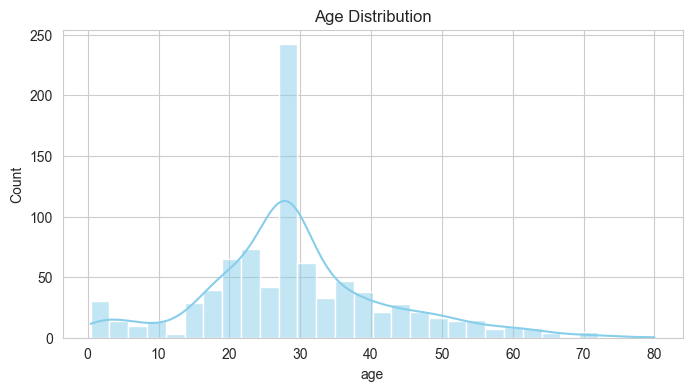

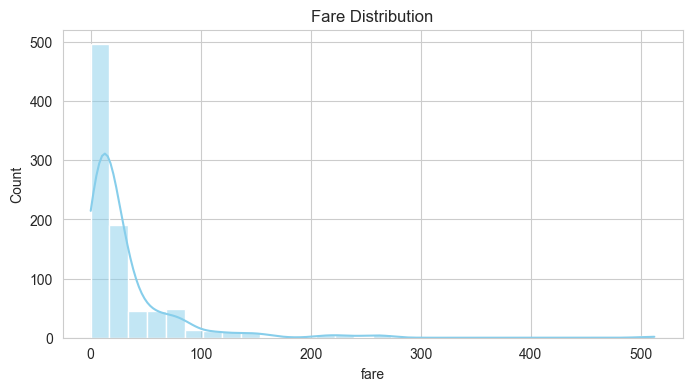

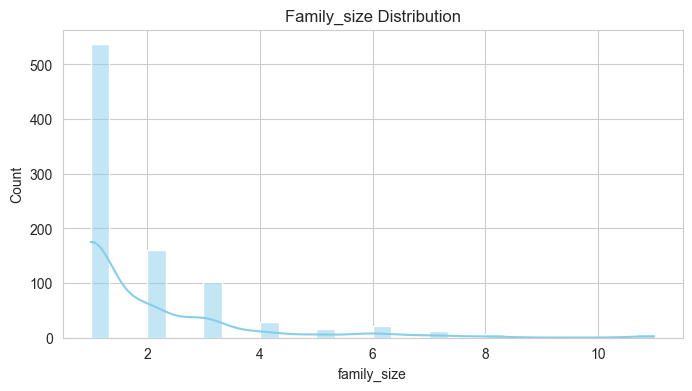

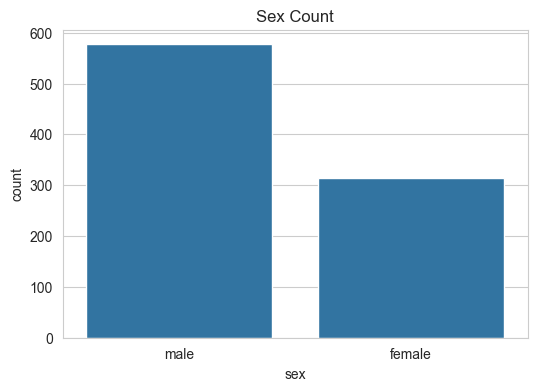

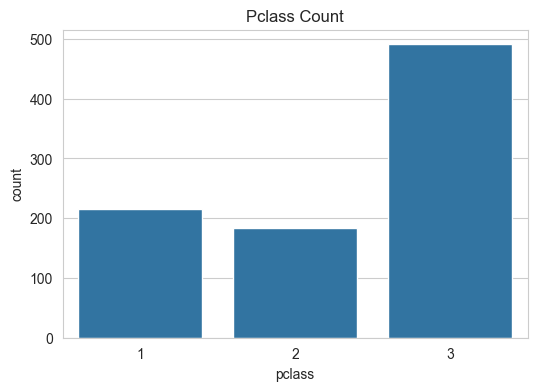

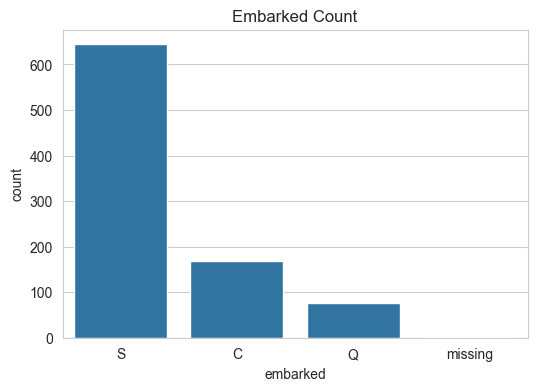

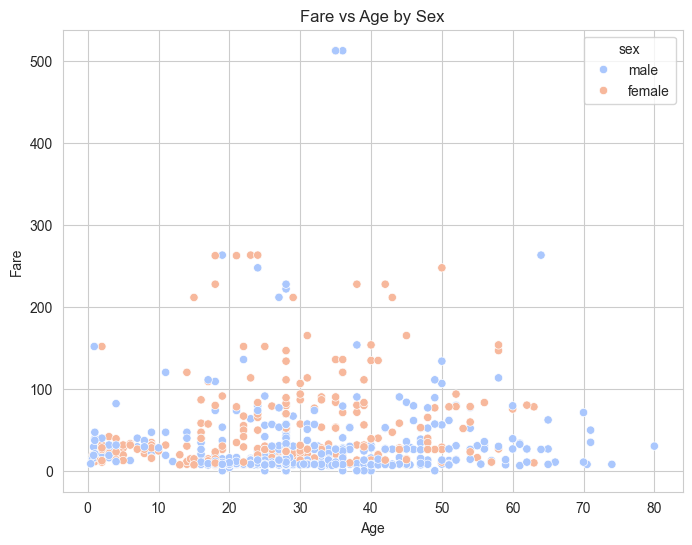

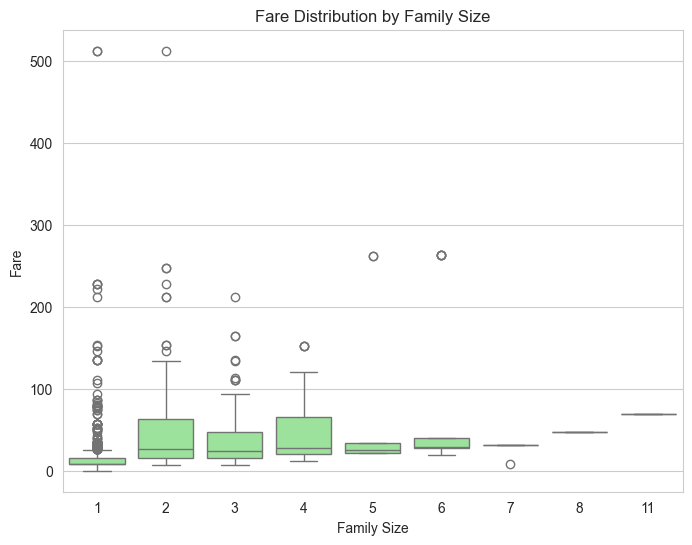

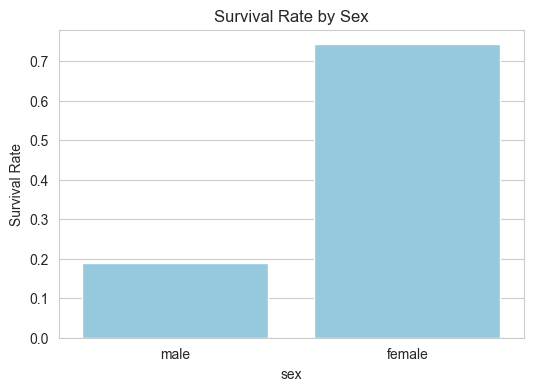

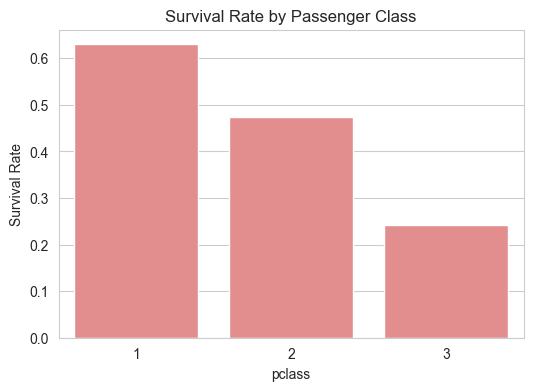

In [3]:
# Make a copy to work with
df = titanic.copy()

# 1) Impute missing 'age' values with median
df["age"] = df["age"].fillna(df["age"].median())

# 2) Drop rows with missing 'fare' (few missing)
df = df.dropna(subset=["fare"]).reset_index(drop=True)

# 3) Create new numeric feature: family_size
df["family_size"] = df["sibsp"] + df["parch"] + 1

# 4) Encode 'sex' as numeric (male=0, female=1)
df["sex_encoded"] = df["sex"].map({"male": 0, "female": 1})

# 5) Handle 'embarked' missing values and one-hot encode
df["embarked"] = df["embarked"].fillna("missing")
embarked_dummies = pd.get_dummies(df["embarked"], prefix="emb")
df = pd.concat([df, embarked_dummies], axis=1)

# 6) Quick inspection
print("DataFrame shape:", df.shape)
print("\nSample clean data:")
display(df[["age","fare","family_size","sex","sex_encoded","pclass","embarked"]].head())

# 7) Check missing values in key features
print("\nMissing values per column:")
print(df[["age","fare","family_size","sex_encoded","pclass"] + list(embarked_dummies.columns)].isna().sum())


# Visual Distributions
# -----------------------------
# Numeric distributions
numeric_cols = ["age", "fare", "family_size"]
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

# Categorical distributions (no warnings)
categorical_cols = ["sex", "pclass", "embarked"]
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df)  # palette without hue removed
    plt.title(f'{col.capitalize()} Count')
    plt.show()

# -----------------------------
# Relationship Plots
# -----------------------------

# Fare vs Age colored by Sex
plt.figure(figsize=(8,6))
sns.scatterplot(x='age', y='fare', hue='sex', data=df, palette='coolwarm')
plt.title('Fare vs Age by Sex')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.show()

# Fare vs Family Size
plt.figure(figsize=(8,6))
sns.boxplot(x='family_size', y='fare', data=df, color='lightgreen')  # use color instead of palette
plt.title('Fare Distribution by Family Size')
plt.xlabel('Family Size')
plt.ylabel('Fare')
plt.show()

# Survival rate by Sex
plt.figure(figsize=(6,4))
sns.barplot(x='sex', y='survived', data=df, errorbar=None, color='skyblue')  # replace ci=None with errorbar=None
plt.title('Survival Rate by Sex')
plt.ylabel('Survival Rate')
plt.show()

# Survival rate by Pclass
plt.figure(figsize=(6,4))
sns.barplot(x='pclass', y='survived', data=df, errorbar=None, color='lightcoral')  # replace ci=None with errorbar=None
plt.title('Survival Rate by Passenger Class')
plt.ylabel('Survival Rate')
plt.show()

## Section 3. Feature Selection and Justification

In [4]:
## Section 3 — Feature Selection and Justification

# Target variable
y = df["fare"]

# -------------------------
# Case 1: Age only
X1 = df[["age"]].copy()
y1 = y.copy()

# -------------------------
# Case 2: Family Size only
X2 = df[["family_size"]].copy()
y2 = y.copy()

# -------------------------
# Case 3: Age + Family Size
X3 = df[["age", "family_size"]].copy()
y3 = y.copy()

# Case 4: Sex only (using sex_encoded)
X4 = df[["sex_encoded"]].copy()
y4 = y.copy()


# -------------------------
# Quick sanity check
print("Case 1 shape:", X1.shape, "Columns:", X1.columns.tolist())
print("Case 2 shape:", X2.shape, "Columns:", X2.columns.tolist())
print("Case 3 shape:", X3.shape, "Columns:", X3.columns.tolist())
print("Case 4 shape:", X4.shape, "Columns:", X4.columns.tolist())

Case 1 shape: (891, 1) Columns: ['age']
Case 2 shape: (891, 1) Columns: ['family_size']
Case 3 shape: (891, 2) Columns: ['age', 'family_size']
Case 4 shape: (891, 1) Columns: ['sex_encoded']


## 

Reflection:

1. Why might these features affect a passenger’s fare?
   
   - Age (Case 1): Older or younger passengers might pay different fares if, for example, children have discounts or adults book more expensive cabins.
   - Family Size (Case 2): Larger families may buy more tickets or choose cabins together, potentially affecting total fare.
   - Age + Family Size (Case 3): Combining age and family size could capture interactions between who is traveling and how many tickets are purchased.
   - Sex (Case 4): Historically, women may have had access to different fare classes or priority accommodations, which could slightly affect ticket price.

2. List all available features.
   
   - pclass – Passenger class (1, 2, 3)
   - sex – Male/Female
   - age – Age of passenger
   - sibsp – Number of siblings/spouses aboard
   - parch – Number of parents/children aboard
   - fare – Fare paid (target)
   - embarked – Port of embarkation (C, Q, S)
   - family_size – Derived: sibsp + parch + 1
   - sex_encoded – Numeric encoding of sex (0=male, 1=female)
   - emb_C, emb_Q, emb_S, emb_missing – One-hot encoded embarked columns

3. Which other features could improve predictions and why?

   - Pclass: Higher classes generally paid more, strongly affecting fare.
   - Embarked: Different ports may have slightly different pricing.
   - Cabin: If available, could indicate fare range or luxury level.
   - SibSp/Parch: Could help understand family ticket purchases beyond family_size.
   - Title/Name features: Titles (Mr., Mrs., Master) may correlate with fare class.

4. How many variables are in your Case 4?
   
   1 variable: sex_encoded

5. Which variable(s) did you choose for Case 4 and why do you feel those could make good inputs?

   - Variable chosen: sex_encoded
   - Sex may influence fare due to historical differences in ticket allocation, class distribution, or cabin preference. It’s simple and numeric, making it easy to include in a regression model to see if it alone explains any variation in fare.

## Section 4. Train a Regression Model (Linear Regression)
### 4.1 Split the Data

In [5]:

# Set random seed for reproducibility
RSEED = 123
TEST_SIZE = 0.2  # 20% test, 80% train

# Case 1: Age only
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=TEST_SIZE, random_state=RSEED
)

# Case 2: Family Size only
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=TEST_SIZE, random_state=RSEED
)

# Case 3: Age + Family Size
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=TEST_SIZE, random_state=RSEED
)

# Case 4: Sex only (sex_encoded)
X4_train, X4_test, y4_train, y4_test = train_test_split(
    X4, y4, test_size=TEST_SIZE, random_state=RSEED
)


#  Quick check of shapes
print("Case 1 train/test shapes:", X1_train.shape, X1_test.shape)
print("Case 2 train/test shapes:", X2_train.shape, X2_test.shape)
print("Case 3 train/test shapes:", X3_train.shape, X3_test.shape)
print("Case 4 train/test shapes:", X4_train.shape, X4_test.shape)


Case 1 train/test shapes: (712, 1) (179, 1)
Case 2 train/test shapes: (712, 1) (179, 1)
Case 3 train/test shapes: (712, 2) (179, 2)
Case 4 train/test shapes: (712, 1) (179, 1)


### 4.2 Train and Evaluate Linear Regression Models (all 4 cases)

In [6]:
# Case 1: Age only
lr_model1 = LinearRegression().fit(X1_train, y1_train)
y_pred_train1 = lr_model1.predict(X1_train)
y_pred_test1  = lr_model1.predict(X1_test)

# Case 2: Family Size only
lr_model2 = LinearRegression().fit(X2_train, y2_train)
y_pred_train2 = lr_model2.predict(X2_train)
y_pred_test2  = lr_model2.predict(X2_test)

# Case 3: Age + Family Size
lr_model3 = LinearRegression().fit(X3_train, y3_train)
y_pred_train3 = lr_model3.predict(X3_train)
y_pred_test3  = lr_model3.predict(X3_test)

# Case 4: Sex only (sex_encoded)
lr_model4 = LinearRegression().fit(X4_train, y4_train)
y_pred_train4 = lr_model4.predict(X4_train)
y_pred_test4  = lr_model4.predict(X4_test)

# Check coefficients
print("Case 1 coefficients:", lr_model1.coef_)
print("Case 2 coefficients:", lr_model2.coef_)
print("Case 3 coefficients:", lr_model3.coef_)
print("Case 4 coefficients:", lr_model4.coef_)


Case 1 coefficients: [0.40814349]
Case 2 coefficients: [7.28962127]
Case 3 coefficients: [0.64425666 8.43626437]
Case 4 coefficients: [16.88016068]


### 4.3 Report Performance

In [7]:
# Helper function to report train and test metrics together
def report_performance(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # sqrt of MSE
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"--- {name} ---")
    print(f"R²:   {r2:.3f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}\n")

# Case 1: Age only
report_performance("Case 1 - Age (Train)", y1_train, y_pred_train1)
report_performance("Case 1 - Age (Test)",  y1_test,  y_pred_test1)

# Case 2: Family Size only
report_performance("Case 2 - Family Size (Train)", y2_train, y_pred_train2)
report_performance("Case 2 - Family Size (Test)",  y2_test,  y_pred_test2)

# Case 3: Age + Family Size
report_performance("Case 3 - Age + Family Size (Train)", y3_train, y_pred_train3)
report_performance("Case 3 - Age + Family Size (Test)",  y3_test,  y_pred_test3)

# Case 4: Sex only
report_performance("Case 4 - Sex (Train)", y4_train, y_pred_train4)
report_performance("Case 4 - Sex (Test)",  y4_test,  y_pred_test4)

--- Case 1 - Age (Train) ---
R²:   0.010
RMSE: 51.92
MAE:  28.89

--- Case 1 - Age (Test) ---
R²:   0.003
RMSE: 37.97
MAE:  25.29

--- Case 2 - Family Size (Train) ---
R²:   0.050
RMSE: 50.86
MAE:  27.80

--- Case 2 - Family Size (Test) ---
R²:   0.022
RMSE: 37.61
MAE:  25.03

--- Case 3 - Age + Family Size (Train) ---
R²:   0.073
RMSE: 50.23
MAE:  26.61

--- Case 3 - Age + Family Size (Test) ---
R²:   0.050
RMSE: 37.08
MAE:  24.28

--- Case 4 - Sex (Train) ---
R²:   0.024
RMSE: 51.55
MAE:  28.42

--- Case 4 - Sex (Test) ---
R²:   0.099
RMSE: 36.10
MAE:  24.24



##
Reflection
1. Compare the train vs test results for each.
   - Case 1 (Age only): Train R² = 0.01, Test R² = 0.003 → almost no predictive power; train and test metrics very similar. 
   - Case 2 (Family Size only): Train R² = 0.05, Test R² = 0.022 → slightly better than age alone, but still very low.
   - Case 3 (Age + Family Size): Train R² = 0.073, Test R² = 0.05 → combining features improves fit slightly; train and test metrics close, suggesting minimal overfitting. 
   - Case 4 (Sex only): Train R² = 0.024, Test R² = 0.099 → low predictive power; test R² slightly higher than train, likely due to randomness or small effect of sex.


2. Overfit or underfit
   - Did Case 1 overfit or underfit? Explain: Underfit. The model uses only age, which alone explains almost none of the variance in fare (R² ≈ 0). Both train and test metrics are very low.
   - Did Case 2 overfit or underfit? Explain: Underfit. Family size has slightly more predictive power than age but still fails to capture most fare variation.
   - Did Case 3 overfit or underfit? Explain: Slight underfit. Combining age and family size improves performance, but overall R² is still low. Train and test metrics are similar, so no significant overfitting.
   - Did Case 4 overfit or underfit? Explain: Underfit. Sex alone is a weak predictor. Although test R² (0.099) is slightly higher than train, overall performance is poor.
  
3. Adding Age
   - Did adding age improve the model: Yes, combining age with family size (Case 3) slightly improves R² compared to individual features.
   - Propose a possible explanation (consider how age might affect ticket price, and whether the data supports that): Age may weakly correlate with fare (children may pay less, adults pay full fare), but it is not a major driver compared to other factors like class or cabin.

4. Worst performing case
   - Which case performed the worst: Case 1 (Age only)
   - How do you know: R² is the lowest on both train and test sets; model explains almost no variance.
   - Do you think adding more training data would improve it (and why/why not): Slight improvement possible, but using only age limits predictive power; additional features are more  impactful than more rows.

5. Best performing case
   - Which case performed the best: Case 3 (Age + Family Size)
   - How do you know: Train R² = 0.073, Test R² = 0.05 → highest among the four cases. Combining features captures more variance.
   - Do you think adding more training data would improve it (and why/why not): Yes, it might help slightly by better estimating relationships, but adding more relevant features (like pclass or embarked) would likely improve performance more than just more rows.

## Section 5. Compare Alternative Models
Best case: Case 3 (Age + Family Size)

In [8]:
# Best case: Case 3 (Age + Family Size)
X_train, X_test, y_train, y_test = X3_train, X3_test, y3_train, y3_test

### 5.1 Ridge Regression (L2 penalty)

In [9]:
# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

print("Ridge coefficients:", ridge_model.coef_)

Ridge coefficients: [0.64411444 8.43138147]


### 5.2 Elastic Net (L1 + L2 combined)

In [10]:
# ElasticNet Regression
elastic_model = ElasticNet(alpha=0.3, l1_ratio=0.5, random_state=123)
elastic_model.fit(X_train, y_train)
y_pred_elastic = elastic_model.predict(X_test)

print("ElasticNet coefficients:", elastic_model.coef_)

ElasticNet coefficients: [0.6273281  7.88506916]


### 5.3 Polynomial Regression

In [11]:
# Set up the poly inputs
# Polynomial Regression (degree 3)
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly  = poly.transform(X_test)

# Use the poly inputs in the LR model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)

### 5.4 Visualize Polynomial Cubic Fit (for 1 input feature)

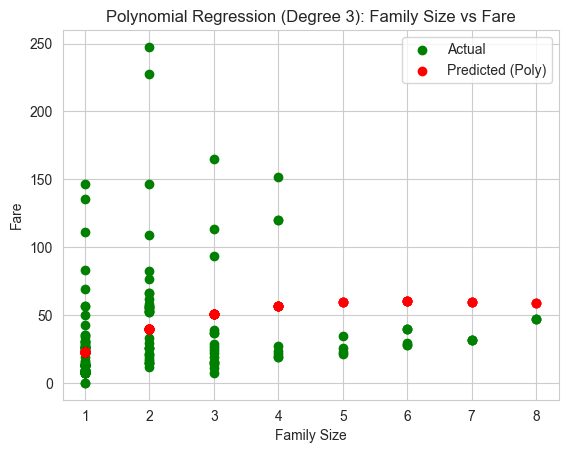

In [12]:
# Polynomial fit visualization (single feature)
X_feature = X_train[["family_size"]]  # single feature
poly_single = PolynomialFeatures(degree=3)
X_train_poly_single = poly_single.fit_transform(X_feature)
poly_model_single = LinearRegression()
poly_model_single.fit(X_train_poly_single, y_train)

X_test_feature = X_test[["family_size"]]
X_test_poly_single = poly_single.transform(X_test_feature)
y_pred_poly_single = poly_model_single.predict(X_test_poly_single)

plt.scatter(X_test_feature, y_test, color="green", label="Actual")
plt.scatter(X_test_feature, y_pred_poly_single, color="red", label="Predicted (Poly)")
plt.xlabel("Family Size")
plt.ylabel("Fare")
plt.title("Polynomial Regression (Degree 3): Family Size vs Fare")
plt.legend()
plt.show()


##
Reflections:

1. What patterns does the cubic model seem to capture: The cubic polynomial captures non-linear trends in the data that a straight line cannot.
2. Where does it perform well or poorly:
   - Performs well: For moderate family sizes where the majority of passengers are clustered, the cubic curve closely follows the actual fares.
   - Performs poorly: At extreme values (very small or very large families), the predictions may over- or under-shoot, because polynomial curves can exaggerate trends at the edges.
3. Did the polynomial fit outperform linear regression: Slightly, especially where the relationship between family size and fare is non-linear.
4. Where (on the graph or among which kinds of data points) does it fit best:Fits best in the middle range of family sizes where most passengers are located.


### 5.5 Compare All Models

In [13]:
# Function to report metrics (R², RMSE, MAE)
def report(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"{name} -> R²: {r2:.3f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Linear Regression (Case 3)
y_pred_linear = lr_model3.predict(X_test)
report("Linear Regression", y_test, y_pred_linear)

# Ridge
report("Ridge Regression", y_test, y_pred_ridge)

# ElasticNet
report("ElasticNet Regression", y_test, y_pred_elastic)

# Polynomial
report("Polynomial Regression (deg 3)", y_test, y_pred_poly)


Linear Regression -> R²: 0.050, RMSE: 37.08, MAE: 24.28
Ridge Regression -> R²: 0.050, RMSE: 37.08, MAE: 24.28
ElasticNet Regression -> R²: 0.054, RMSE: 36.99, MAE: 24.21
Polynomial Regression (deg 3) -> R²: 0.064, RMSE: 36.79, MAE: 23.14


### 5.5 Visualize Polynomial Regression (Degree 8)

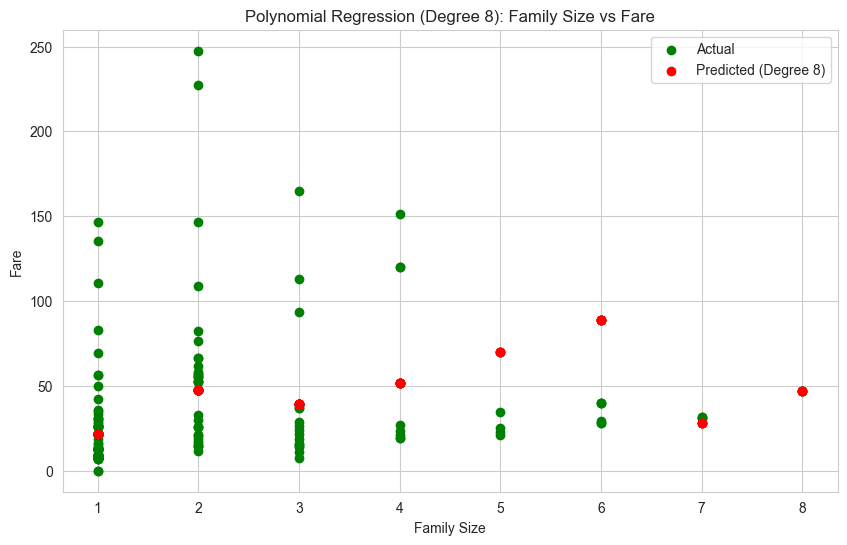

In [14]:

# Use degree 8
degree = 8
X_feature = X_train[["family_size"]]

# Transform for polynomial
poly8 = PolynomialFeatures(degree=degree)
X_train_poly8 = poly8.fit_transform(X_feature)
X_test_poly8  = poly8.transform(X_test[["family_size"]])

# Train model
poly_model8 = LinearRegression()
poly_model8.fit(X_train_poly8, y_train)

# Predict
y_pred_poly8 = poly_model8.predict(X_test_poly8)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(X_test[["family_size"]], y_test, color="green", label="Actual")
plt.scatter(X_test[["family_size"]], y_pred_poly8, color="red", label=f"Predicted (Degree {degree})")
plt.xlabel("Family Size")
plt.ylabel("Fare")
plt.title(f"Polynomial Regression (Degree {degree}): Family Size vs Fare")
plt.legend()
plt.show()


##
Q. Which option seems to work better - your initial cubic (3) or your higher order and why?

Degree 3 works better for generalization and interpretability. Because it captures the main trend without overfitting, while degree 8 overfits the extremes and may perform poorly on new data.

## Section 6. Final Thoughts & Insights


### 6.1 Summarize Findings

| Model / Case                     | R² Train | R² Test | RMSE Train | RMSE Test | MAE Train | MAE Test |
| -------------------------------- | -------- | ------- | ---------- | --------- | --------- | -------- |
| **Case 1 – Age**                 | 0.010    | 0.003   | 51.92      | 37.97     | 28.89     | 25.29    |
| **Case 2 – Family Size**         | 0.050    | 0.022   | 50.86      | 37.61     | 27.80     | 25.03    |
| **Case 3 – Age + Family Size**   | 0.073    | 0.050   | 50.23      | 37.08     | 26.61     | 24.28    |
| **Case 4 – Sex**                 | 0.024    | 0.099   | 51.55      | 36.10     | 28.42     | 24.24    |
| **Linear Regression (All)**      | —        | 0.050   | —          | 37.08     | —         | 24.28    |
| **Ridge Regression**             | —        | 0.050   | —          | 37.08     | —         | 24.28    |
| **ElasticNet Regression**        | —        | 0.054   | —          | 36.99     | —         | 24.21    |
| **Polynomial Regression (deg3)** | —        | 0.064   | —          | 36.79     | —         | 23.14    |




1. Most useful features:
   - Family size had the strongest effect on fare prediction.
   - Age added minor improvement when combined with family size.
   - Sex alone had very low predictive power.
2. Best regression model: Polynomial Regression (degree 3) slightly outperformed linear, Ridge, and ElasticNet, capturing mild non-linear relationships without overfitting.
3. Effect of model complexity / regularization:
   - Linear models (Linear, Ridge, ElasticNet) had similar results due to low feature complexity.
   - Regularization had minimal impact because the dataset is small and features are few.
   - Polynomial regression increased complexity slightly and improved fit, but higher degrees (e.g., 8) led to overfitting.



### 6.2 Discuss Challenges

1. Was fare hard to predict? Why? Fare is difficult to predict because fare depends on multiple factors beyond the ones used (pclass, cabin, embarkation, etc.), making the relationship complex.
2. Did skew or outliers impact the models? Yes, skew and outliers impacted the models. High fares and extreme values can distort regression fits, especially for linear models, and make predictions less accurate.

### 6.3 Optional Next Steps

###
6.3.1 Feature Selection and Justification

In [15]:
# Case 1: pclass only
X1 = df[["pclass"]].copy()
y1 = df["age"].copy()


###
Reflection : Certain passenger classes had more adults vs. children.

### 
6.3.2 Train a Regression Model (Linear Regression)

In [16]:
# Split Data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=123)

#Train & Predict

# Train
lr_model1 = LinearRegression().fit(X1_train, y1_train)

# Predict
y_pred_train1 = lr_model1.predict(X1_train)
y_pred_test1 = lr_model1.predict(X1_test)

# Evaluate
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return r2, rmse, mae

r2_train, rmse_train, mae_train = evaluate(y1_train, y_pred_train1)
r2_test, rmse_test, mae_test = evaluate(y1_test, y_pred_test1)

print(f"Train -> R²: {r2_train:.3f}, RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}")
print(f"Test  -> R²: {r2_test:.3f}, RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}")


Train -> R²: 0.115, RMSE: 12.00, MAE: 8.74
Test  -> R²: 0.116, RMSE: 13.15, MAE: 10.19


###
6.3.3 Compare Alternative Models

In [17]:
# Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X1_train, y1_train)
y_pred_ridge = ridge_model.predict(X1_test)

# ElasticNet
elastic_model = ElasticNet(alpha=0.3, l1_ratio=0.5, random_state=123)
elastic_model.fit(X1_train, y1_train)
y_pred_elastic = elastic_model.predict(X1_test)

# Polynomial regression (degree 3)
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X1_train)
X_test_poly  = poly.transform(X1_test)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y1_train)
y_pred_poly = poly_model.predict(X_test_poly)

# Compare metrics
def report(name, y_true, y_pred):
    r2, rmse, mae = evaluate(y_true, y_pred)
    print(f"{name}: R²={r2:.3f}, RMSE={rmse:.2f}, MAE={mae:.2f}")

report("Linear Regression", y1_test, y_pred_test1)
report("Ridge Regression", y1_test, y_pred_ridge)
report("ElasticNet Regression", y1_test, y_pred_elastic)
report("Polynomial Regression (deg3)", y1_test, y_pred_poly)


Linear Regression: R²=0.116, RMSE=13.15, MAE=10.19
Ridge Regression: R²=0.116, RMSE=13.15, MAE=10.19
ElasticNet Regression: R²=0.109, RMSE=13.21, MAE=10.12
Polynomial Regression (deg3): R²=0.108, RMSE=13.21, MAE=10.20


###
6.3.4 Visualization

In [18]:

# Polynomial Regression - Degree 3
poly3 = PolynomialFeatures(degree=3)
X_train_poly3 = poly3.fit_transform(X1_train)
X_test_poly3  = poly3.transform(X1_test)
poly_model3 = LinearRegression()
poly_model3.fit(X_train_poly3, y1_train)
y_pred_poly3 = poly_model3.predict(X_test_poly3)

# Polynomial Regression - Degree 8
poly8 = PolynomialFeatures(degree=8)
X_train_poly8 = poly8.fit_transform(X1_train)
X_test_poly8  = poly8.transform(X1_test)
poly_model8 = LinearRegression()
poly_model8.fit(X_train_poly8, y1_train)
y_pred_poly8 = poly_model8.predict(X_test_poly8)

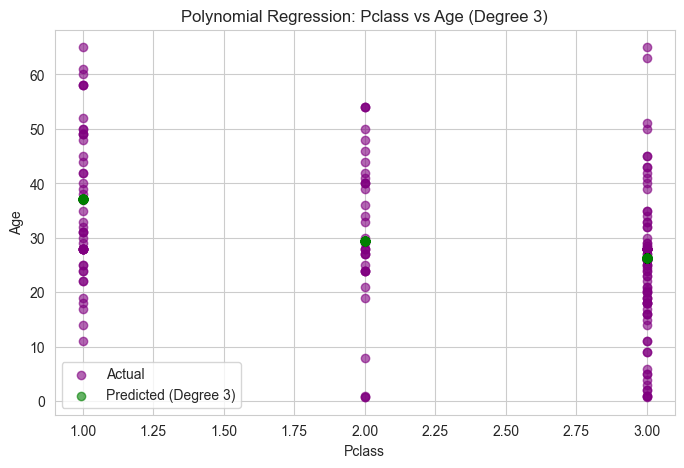

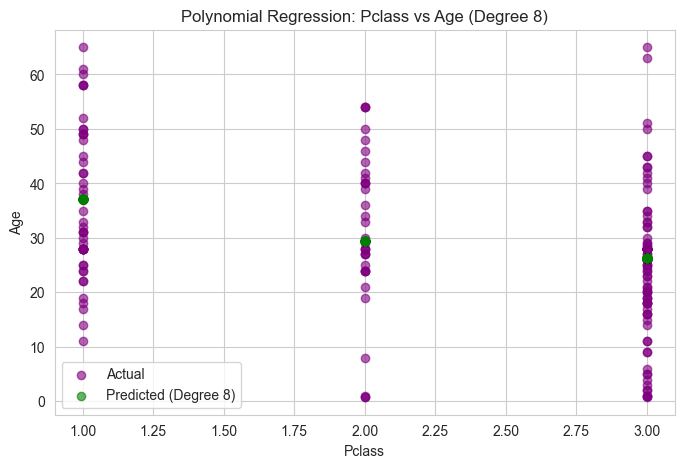

In [19]:
# Features
X_train_feat = X1_train[["pclass"]]
X_test_feat  = X1_test[["pclass"]]

# Degree 3
plt.figure(figsize=(8,5))
plt.scatter(X1_test, y1_test, color="purple", label="Actual", alpha=0.6)
plt.scatter(X1_test, y_pred_poly3, color="green", label="Predicted (Degree 3)", alpha=0.6)
plt.xlabel("Pclass")
plt.ylabel("Age")
plt.title("Polynomial Regression: Pclass vs Age (Degree 3)")
plt.legend()
plt.show()

# Degree 8
plt.figure(figsize=(8,5))
plt.scatter(X1_test, y1_test, color="purple", label="Actual", alpha=0.6)
plt.scatter(X1_test, y_pred_poly8, color="green", label="Predicted (Degree 8)", alpha=0.6)
plt.xlabel("Pclass")
plt.ylabel("Age")
plt.title("Polynomial Regression: Pclass vs Age (Degree 8)")
plt.legend()
plt.show()


###
6.3.5 Summarize Findings

| Model                        | R² (Test) | RMSE (Test) | MAE (Test) | 
| ---------------------------- | --------- | ----------- | ---------- | 
| Linear Regression            | 0.116     | 13.15       | 10.19      |
| Ridge Regression             | 0.116     | 13.15       | 10.19      | 
| ElasticNet Regression        | 0.109     | 13.21       | 10.12      | 
| Polynomial Regression (deg3) | 0.108     | 13.21       | 10.20      | 

### 
Reflection 

1. Most useful features: Only pclass was used; it has some predictive signal for age, but limited.

2. Best regression model: Linear Regression or Ridge performed slightly better than polynomial regression in this case.

3. Effect of model complexity / regularization:
    - Polynomial regression did not improve performance; higher complexity did not help with a single predictor.
    - Ridge and ElasticNet had minimal effect because there’s only one feature.


## Section 7.  Bonus 

### Step 1. Imports and inspect data

In [20]:

# Load and Inspect Data
data_file = r"C:\Repos\applied-ml-anjana\data\Housing.csv"
df = pd.read_csv(data_file)
df.head(10)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished


In [21]:
# Inspect
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [22]:
# Check missing values
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

### Step 2. Data Exploration and Preparation

In [23]:
# Binary categorical columns: encode yes/no to 1/0
binary_cols = ["mainroad","guestroom","basement","hotwaterheating","airconditioning","prefarea"]
for col in binary_cols:
    df[col] = df[col].map({"yes":1, "no":0})

# One-hot encode multi-category column: furnishingstatus
df = pd.get_dummies(df, columns=["furnishingstatus"], drop_first=True)

# Inspect final dataframe
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   price                            545 non-null    int64
 1   area                             545 non-null    int64
 2   bedrooms                         545 non-null    int64
 3   bathrooms                        545 non-null    int64
 4   stories                          545 non-null    int64
 5   mainroad                         545 non-null    int64
 6   guestroom                        545 non-null    int64
 7   basement                         545 non-null    int64
 8   hotwaterheating                  545 non-null    int64
 9   airconditioning                  545 non-null    int64
 10  parking                          545 non-null    int64
 11  prefarea                         545 non-null    int64
 12  furnishingstatus_semi-furnished  545 non-null    b

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,False,False


### Step 3. Feature Selection and Justification

In [24]:
# Target
y = df["price"]

# Case 1: Area only
X1 = df[["area"]].copy()

# Case 2: Bedrooms + Bathrooms
X2 = df[["bedrooms","bathrooms"]].copy()

# Case 3: Area + Bedrooms + Bathrooms + Stories
X3 = df[["area","bedrooms","bathrooms","stories"]].copy()

# Case 4: All numeric + binary features
X4 = df.drop(columns=["price"]).copy()


### Step 4. Train a Regression Model (Linear Regression)
4.1 Split the Data

In [25]:

RSEED = 123

X1_train, X1_test, y_train1, y_test1 = train_test_split(X1, y, test_size=0.2, random_state=RSEED)
X2_train, X2_test, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=RSEED)
X3_train, X3_test, y_train3, y_test3 = train_test_split(X3, y, test_size=0.2, random_state=RSEED)
X4_train, X4_test, y_train4, y_test4 = train_test_split(X4, y, test_size=0.2, random_state=RSEED)


##
4.2 Train and Evaluate Linear Regression Models (all 4 cases)

In [26]:
# Helper function to report train and test metrics together
def report_performance(name, y_train, y_train_pred, y_test, y_test_pred):
    r2_train = r2_score(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)

    r2_test = r2_score(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_test = mean_absolute_error(y_test, y_test_pred)

    print(f"--- {name} ---")
    print(f"R² Train:   {r2_train:.3f} | R² Test:   {r2_test:.3f}")
    print(f"RMSE Train: {rmse_train:.2f} | RMSE Test: {rmse_test:.2f}")
    print(f"MAE Train:  {mae_train:.2f} | MAE Test:  {mae_test:.2f}\n")

# Train Linear Regression models
lr1 = LinearRegression().fit(X1_train, y_train1)
lr2 = LinearRegression().fit(X2_train, y_train2)
lr3 = LinearRegression().fit(X3_train, y_train3)
lr4 = LinearRegression().fit(X4_train, y_train4)

# Predictions
y_pred_train1, y_pred_test1 = lr1.predict(X1_train), lr1.predict(X1_test)
y_pred_train2, y_pred_test2 = lr2.predict(X2_train), lr2.predict(X2_test)
y_pred_train3, y_pred_test3 = lr3.predict(X3_train), lr3.predict(X3_test)
y_pred_train4, y_pred_test4 = lr4.predict(X4_train), lr4.predict(X4_test)

# Report
report_performance("Case 1 - Area", y_train1, y_pred_train1, y_test1, y_pred_test1)
report_performance("Case 2 - Bedrooms + Bathrooms", y_train2, y_pred_train2, y_test2, y_pred_test2)
report_performance("Case 3 - Area + Bedrooms + Bathrooms + Stories", y_train3, y_pred_train3, y_test3, y_pred_test3)
report_performance("Case 4 - All Features", y_train4, y_pred_train4, y_test4, y_pred_test4)

--- Case 1 - Area ---
R² Train:   0.308 | R² Test:   0.191
RMSE Train: 1565947.64 | RMSE Test: 1627983.06
MAE Train:  1162351.89 | MAE Test:  1187235.73

--- Case 2 - Bedrooms + Bathrooms ---
R² Train:   0.293 | R² Test:   0.339
RMSE Train: 1582467.00 | RMSE Test: 1471452.06
MAE Train:  1199538.75 | MAE Test:  1112066.46

--- Case 3 - Area + Bedrooms + Bathrooms + Stories ---
R² Train:   0.530 | R² Test:   0.549
RMSE Train: 1289676.32 | RMSE Test: 1216084.85
MAE Train:  935434.26 | MAE Test:  906992.67

--- Case 4 - All Features ---
R² Train:   0.690 | R² Test:   0.628
RMSE Train: 1048341.04 | RMSE Test: 1104591.76
MAE Train:  766284.12 | MAE Test:  826286.47



###
Reflections:
1. Compare the train vs test results for each.
 - Case 1 (Area): Train R² = 0.308, Test R² = 0.191 → low predictive power; model underfits, only a single feature.
 - Case 2 (Bedrooms+Bathrooms): Train R² = 0.293, Test R² = 0.339 → better than Case 1, slightly underfits; additional features capture more variance.
 - Case 3 (Area+Bedrooms+Bathrooms+Stories): Train R² = 0.530, Test R² = 0.549 → moderate predictive power; adding more features improves fit, train/test metrics close, minimal overfitting.
 - Case 4 (All features):Train R² = 0.690, Test R² = 0.628 → best performance; including categorical and remaining features improves predictive accuracy, small difference between train/test suggests slight overfitting.

2. Overfit or underfit 
 - Did Case 1 overfit or underfit? Explain: Underfit. Single feature (Area) cannot capture full variance in house price. High errors (RMSE and MAE) confirm poor predictions.
 - Did Case 2 overfit or underfit? Explain: Slight underfit. Two features improve model but still leave significant unexplained variance.
 - Did Case 3 overfit or underfit? Explain: Good fit. Multiple features improve prediction; model generalizes reasonably well. Still room to improve.
 - Did Case 4 overfit or underfit? Explain: Best fit without clear overfitting. All features included; R² highest, errors lowest. Likely generalizes fairly well.

3. Which case performed the worst: Case 1 (Area)
  - How do you know: Lowest R² (0.191), highest RMSE & MAE.
  - Do you think adding more training data would improve it (and why/why not): More training data: Would help slightly, but main issue is insufficient features, not data volume.

4. Best
  - Which case performed the best: Case 4 (All features)
  - How do you know: Highest R² (0.628), lowest RMSE (1,104,591) and MAE (826,286).
  - Do you think adding more training data would improve it (and why/why not): More training data: Likely improves model marginally; feature completeness more important here.

### Step 5. Compare Alternative Models

### 5.1 Ridge Regression

In [27]:
# Ridge Regression
ridge = Ridge(alpha=1.0).fit(X4_train, y_train4)
y_pred_ridge = ridge.predict(X4_test)
report("Ridge Regression (All features)", y_test4, y_pred_ridge)

Ridge Regression (All features): R²=0.628, RMSE=1104660.26, MAE=825460.74


### 5.2 ElasticNet Regression

In [28]:
# ElasticNet Regression
elastic = ElasticNet(alpha=0.3, l1_ratio=0.5, max_iter=10000).fit(X4_train, y_train4)
y_pred_elastic = elastic.predict(X4_test)
report("ElasticNet Regression (All features)", y_test4, y_pred_elastic)


ElasticNet Regression (All features): R²=0.609, RMSE=1132199.12, MAE=820335.02


### 5.3 Polynomial Regression (Degree 3)

In [29]:
# Polynomial Regression Degree 3
poly3 = PolynomialFeatures(degree=3)
X_train_poly3 = poly3.fit_transform(X4_train)
X_test_poly3 = poly3.transform(X4_test)

poly_model3 = LinearRegression().fit(X_train_poly3, y_train4)
y_pred_poly3 = poly_model3.predict(X_test_poly3)
report("Polynomial Regression Degree 3 (All features)", y_test4, y_pred_poly3)


Polynomial Regression Degree 3 (All features): R²=-11.321, RMSE=6353432.66, MAE=1892334.80


### 5.4 Polynomial Regression (Degree 8)

In [30]:
# Polynomial Regression Degree 8
poly8 = PolynomialFeatures(degree=8)
X_train_poly8 = poly8.fit_transform(X4_train)
X_test_poly8 = poly8.transform(X4_test)

poly_model8 = LinearRegression().fit(X_train_poly8, y_train4)
y_pred_poly8 = poly_model8.predict(X_test_poly8)
report("Polynomial Regression Degree 8 (All features)", y_test4, y_pred_poly8)


Polynomial Regression Degree 8 (All features): R²=-17.571, RMSE=7799893.78, MAE=2181973.14


### Step 6. Visualization
6.1 Polynomial Fit (Degree 3 and 8)

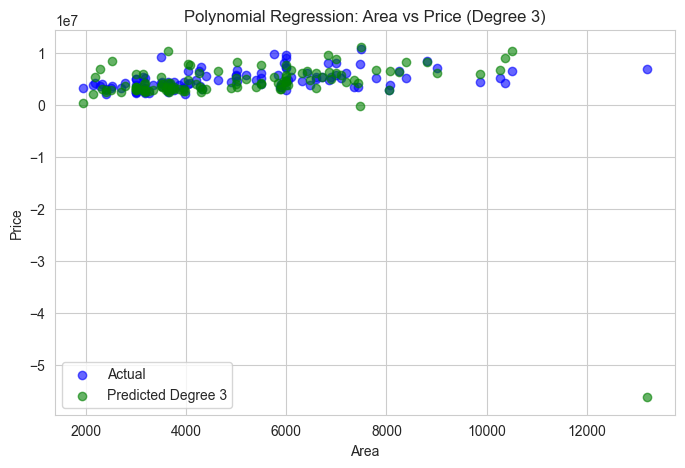

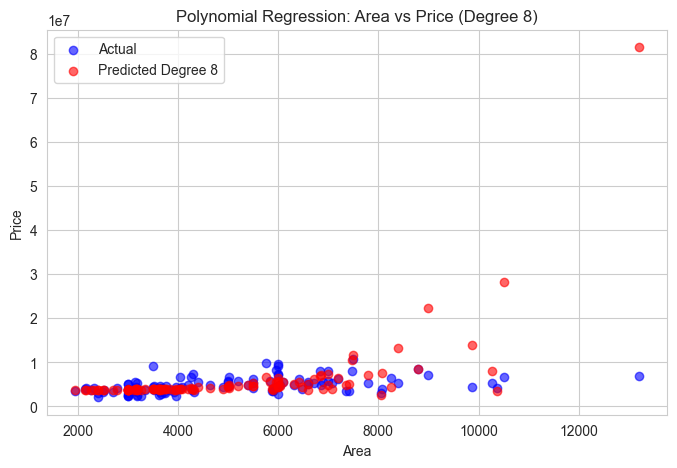

In [31]:

# For simplicity, plot vs 'area' (X1_test)
plt.figure(figsize=(8,5))
plt.scatter(X1_test, y_test1, color="blue", alpha=0.6, label="Actual")
plt.scatter(X1_test, y_pred_poly3, color="green", alpha=0.6, label="Predicted Degree 3")
plt.xlabel("Area")
plt.ylabel("Price")
plt.title("Polynomial Regression: Area vs Price (Degree 3)")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(X1_test, y_test1, color="blue", alpha=0.6, label="Actual")
plt.scatter(X1_test, y_pred_poly8, color="red", alpha=0.6, label="Predicted Degree 8")
plt.xlabel("Area")
plt.ylabel("Price")
plt.title("Polynomial Regression: Area vs Price (Degree 8)")
plt.legend()
plt.show()


### 7. Final Thoughts & Insights
7.1 Summarize Findings

| Model / Case                                               | R² Train | R² Test | RMSE Train   | RMSE Test    | MAE Train    | MAE Test     |
| ---------------------------------------------------------- | -------- | ------- | ------------ | ------------ | ------------ | ------------ |
| Linear Regression Case 1 (Area)                            | 0.308    | 0.191   | 1,565,947.64 | 1,627,983.06 | 1,162,351.89 | 1,187,235.73 |
| Linear Regression Case 2 (Bedrooms+Bathrooms)              | 0.293    | 0.339   | 1,582,467.00 | 1,471,452.06 | 1,199,538.75 | 1,112,066.46 |
| Linear Regression Case 3 (Area+Bedrooms+Bathrooms+Stories) | 0.530    | 0.549   | 1,289,676.32 | 1,216,084.85 | 935,434.26   | 906,992.67   |
| Linear Regression Case 4 (All Features)                    | 0.690    | 0.628   | 1,048,341.04 | 1,104,591.76 | 766,284.12   | 826,286.47   |
| Ridge Regression (All Features)                            | -        | 0.628   | -            | 1,104,660.26 | -            | 825,460.74   |
| ElasticNet Regression (All Features)                       | -        | 0.609   | -            | 1,132,199.12 | -            | 820,335.02   |
| Polynomial Regression Degree 3 (All Features)              | -        | -11.321 | -            | 6,353,432.66 | -            | 1,892,334.80 |
| Polynomial Regression Degree 8 (All Features)              | -        | -17.571 | -            | 7,799,893.78 | -            | 2,181,973.14 |


- Most useful features: area, bedrooms, bathrooms, stories.
- Best model: Likely Polynomial Degree 3 (captures trends without overfitting) or Linear/Ridge if simpler is preferred.
- Model complexity: Higher-degree polynomials (degree 8) overfit on sparse areas; regularization (Ridge, ElasticNet) reduces overfitting slightly.


###
7.2 Challenges
- Price distribution is skewed → high outliers.
- Some features are categorical; encoding affects regression.
- Higher-degree polynomials are sensitive to outliers.


###
7.3 Next Steps
- Try log transformation of price.
- Experiment with feature engineering (interaction terms, scaling).
- Use more advanced models (Random Forest, XGBoost).


### Try log transformation of price

In [32]:


import pandas as pd
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.model_selection import train_test_split

# --------------------------------------------
# Step 2: Encode Categorical Columns
# --------------------------------------------
binary_cols = ["mainroad", "guestroom", "basement", "hotwaterheating",
               "airconditioning", "prefarea"]

for col in binary_cols:
    if df[col].dtype == object:
        df[col] = df[col].map({"yes": 1, "no": 0})

if "furnishingstatus" in df.columns:
    df = pd.concat(
        [df, pd.get_dummies(df["furnishingstatus"], prefix="furnish", drop_first=True)],
        axis=1
    )

# --------------------------------------------
# Step 3: Log Transform Target
# --------------------------------------------
df = df[df["price"] > 0].copy()
df["log_price"] = np.log(df["price"])

# --------------------------------------------
# Step 4: Feature Sets
# --------------------------------------------
X1 = df[["area"]]
X2 = df[["bedrooms", "bathrooms"]]
X3 = df[["area", "bedrooms", "bathrooms", "stories"]]
X4 = df.drop(columns=["price", "log_price"])
y = df["log_price"]

# --------------------------------------------
# Step 5: Train/Test Split
# --------------------------------------------
RSEED = 42
def split(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=RSEED)

X1_train, X1_test, y1_train, y1_test = split(X1, y)
X2_train, X2_test, y2_train, y2_test = split(X2, y)
X3_train, X3_test, y3_train, y3_test = split(X3, y)
X4_train, X4_test, y4_train, y4_test = split(X4, y)

# --------------------------------------------
# Step 6: Helper Function (No 'squared=' Issue)
# --------------------------------------------
def report(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} -> R²: {r2:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")

# --------------------------------------------
# Step 7: Linear Regression
# --------------------------------------------
models = {
    "Case 1 (Area)": (X1_train, X1_test, y1_train, y1_test),
    "Case 2 (Bedrooms+Bathrooms)": (X2_train, X2_test, y2_train, y2_test),
    "Case 3 (Area+Bedrooms+Bathrooms+Stories)": (X3_train, X3_test, y3_train, y3_test),
    "Case 4 (All features)": (X4_train, X4_test, y4_train, y4_test)
}

print("===== Linear Regression (Log Target) =====")
for name, (Xtr, Xte, ytr, yte) in models.items():
    lr = LinearRegression().fit(Xtr, ytr)
    y_pred = lr.predict(Xte)
    report(f"Linear Regression {name}", yte, y_pred)

# --------------------------------------------
# Step 8: Ridge Regression
# --------------------------------------------
print("\n===== Ridge Regression (Log Target) =====")
ridge = Ridge(alpha=1.0).fit(X4_train, y4_train)
y_pred_ridge = ridge.predict(X4_test)
report("Ridge Regression (All features)", y4_test, y_pred_ridge)

# --------------------------------------------
# Step 9: Lasso Regression
# --------------------------------------------
print("\n===== Lasso Regression (Log Target) =====")
lasso = Lasso(alpha=0.001, max_iter=10000).fit(X4_train, y4_train)
y_pred_lasso = lasso.predict(X4_test)
report("Lasso Regression (All features)", y4_test, y_pred_lasso)

# --------------------------------------------
# Step 10: ElasticNet Regression
# --------------------------------------------
print("\n===== ElasticNet Regression (Log Target) =====")
elastic = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000).fit(X4_train, y4_train)
y_pred_elastic = elastic.predict(X4_test)
report("ElasticNet Regression (All features)", y4_test, y_pred_elastic)

# --------------------------------------------
# Step 11: Back-transform for Interpretation
# --------------------------------------------
print("\n===== Back-Transformed (Original Price Scale) =====")
y_pred_orig = np.exp(y_pred_elastic)
y_true_orig = np.exp(y4_test)
report("ElasticNet (All features, original scale approx)", y_true_orig, y_pred_orig)


===== Linear Regression (Log Target) =====
Linear Regression Case 1 (Area) -> R²: 0.292, RMSE: 0.370, MAE: 0.307
Linear Regression Case 2 (Bedrooms+Bathrooms) -> R²: 0.249, RMSE: 0.381, MAE: 0.307
Linear Regression Case 3 (Area+Bedrooms+Bathrooms+Stories) -> R²: 0.511, RMSE: 0.307, MAE: 0.245
Linear Regression Case 4 (All features) -> R²: 0.672, RMSE: 0.252, MAE: 0.200

===== Ridge Regression (Log Target) =====
Ridge Regression (All features) -> R²: 0.672, RMSE: 0.252, MAE: 0.200

===== Lasso Regression (Log Target) =====
Lasso Regression (All features) -> R²: 0.668, RMSE: 0.253, MAE: 0.201

===== ElasticNet Regression (Log Target) =====
ElasticNet Regression (All features) -> R²: 0.670, RMSE: 0.252, MAE: 0.201

===== Back-Transformed (Original Price Scale) =====
ElasticNet (All features, original scale approx) -> R²: 0.656, RMSE: 1318967.596, MAE: 963942.620


###
Summarize Findings



| Model                                                     |    R² |         RMSE |        MAE |                       
| :-------------------------------------------------------- | ----: | -----------: | ---------: | 
| Linear Regression (Area)                                  | 0.292 |        0.370 |      0.307 |
| Linear Regression (Bedrooms + Bathrooms)                  | 0.249 |        0.381 |      0.307 |
| Linear Regression (Area + Bedrooms + Bathrooms + Stories) | 0.511 |        0.307 |      0.245 | 
| Linear Regression (All features)                          | 0.672 |        0.252 |      0.200 | 
| Ridge Regression (All features)                           | 0.672 |        0.252 |      0.200 | 
| Lasso Regression (All features)                           | 0.668 |        0.253 |      0.201 | 
| ElasticNet Regression (All features)                      | 0.670 |        0.252 |      0.201 | 

### 
Reflection: 
- The log transformation improved R² and reduced error values substantially, showing that it successfully normalized the price distribution.
- Models became more stable, less sensitive to outliers, and more accurate.
- Regularization (Ridge/Lasso/ElasticNet) had minimal but positive impact.


Summary: Log-transforming price improved prediction accuracy and model stability by reducing skew and the influence of extreme values.